In [4]:
import numpy as np
import pandas as pd
from scipy import stats
import datetime
import plotly.express as px
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")


In [5]:
import sys
sys.path.insert(0,'../scripts/')
from data_preProcessing import dataProcessor
from data_cleaning import dataCleaner
from data_exploration import dataExplorer

In [6]:
store_df = pd.read_csv('../data/store.csv')
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [7]:
cl_testStore = pd.read_csv('../data/cl_testStore.csv')
cl_trainStore = pd.read_csv('../data/cl_trainStore.csv')

# Run through the bullet points that are expected to conduct an excellent analysis, mentioned in the week challenge document

### 1. Check for distribution in both training and test sets. Are the promotions distributed similarily between these two groups?

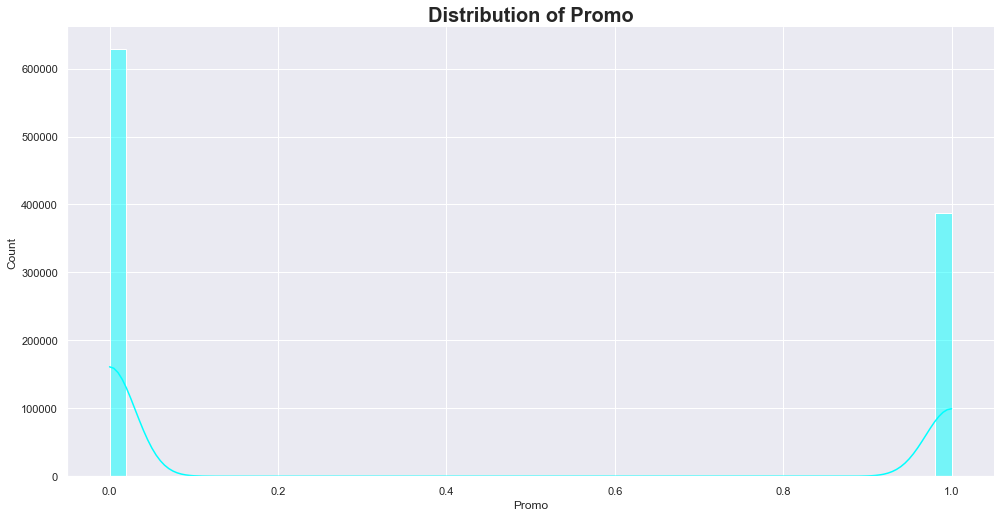

In [8]:
dataExplorer.plot_hist(train_df, 'Promo', 'cyan')

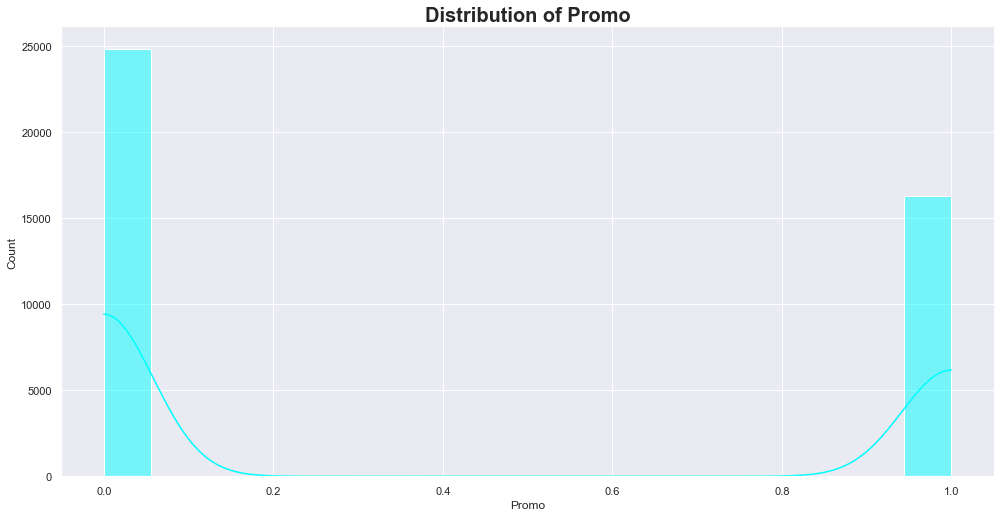

In [9]:
dataExplorer.plot_hist(test_df, 'Promo', 'cyan')

In [10]:
train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [11]:
test_df.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


### sales per Promotion 

In [12]:
sales_promo = train_df.groupby('Promo')["Sales"].sum()
promo_sale = pd.DataFrame({'Promo':sales_promo.index, 'sales_sum_perPromo':sales_promo.values})
promo_sale.head()

,Promo,sales_sum_perPromo
0,0,2771974337
1,1,3101206286


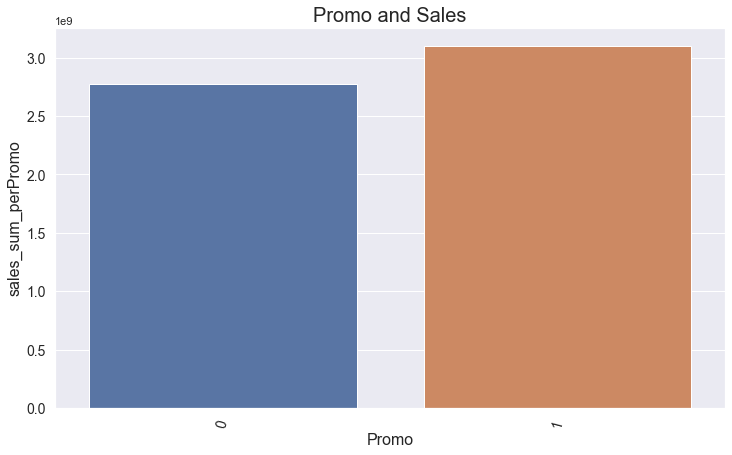

In [13]:
dataExplorer.plot_bar(promo_sale, 'Promo', 'sales_sum_perPromo', 'Promo and Sales', 'Promo', 'sales_sum_perPromo')

### Customers per Promotion

In [14]:
customers_promo = train_df.groupby('Promo')["Customers"].sum()

promo_customers= pd.DataFrame({'Promo':customers_promo.index, 'Customers':customers_promo.values})
promo_customers.head()

,Promo,Customers
0,0,325777807
1,1,318263948


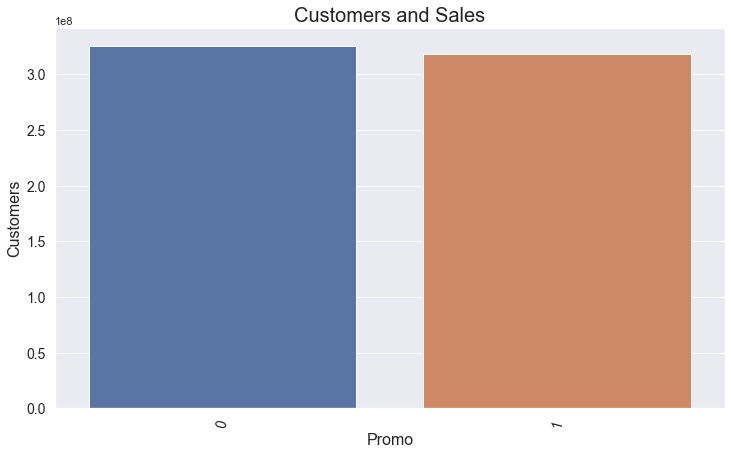

In [15]:
dataExplorer.plot_bar(promo_customers, 'Promo', 'Customers', 'Customers and Sales', 'Promo', 'Customers')

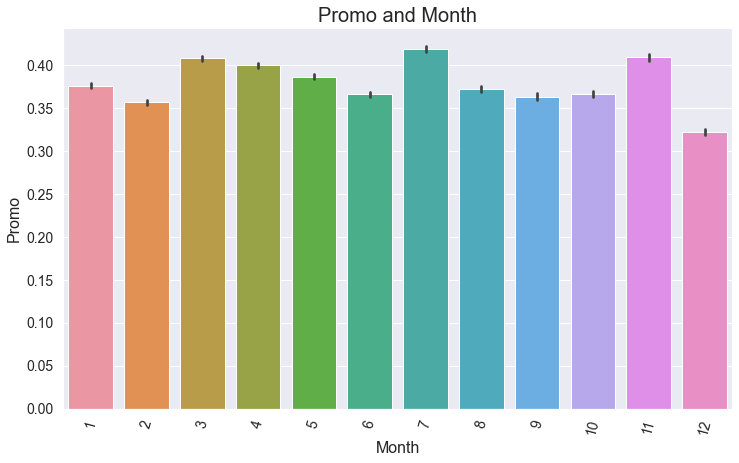

In [16]:
dataExplorer.plot_bar(cl_trainStore, 'Month', 'Promo', 'Promo and Month', 'Month', 'Promo')

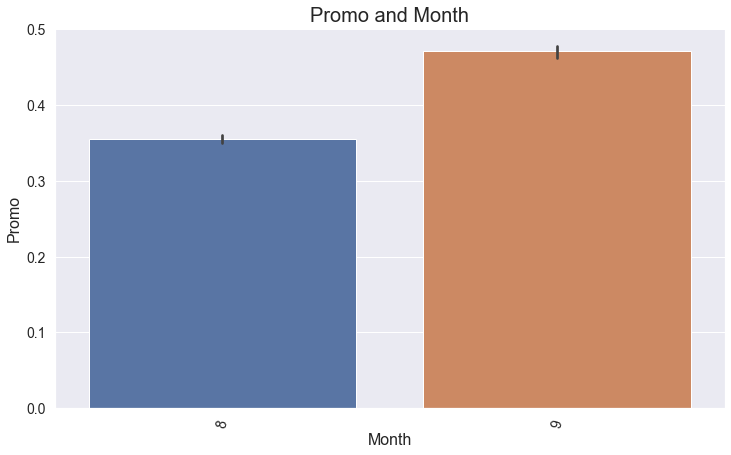

In [17]:
dataExplorer.plot_bar(cl_testStore, 'Month', 'Promo', 'Promo and Month', 'Month', 'Promo')

### * From the first histogram plots, the counts of promotion values (1=promotion, 0=no promotion), counts of 0s are more. But amplitudes differ.
### * For both sets, the mean is greater than the median for the promo column. Therefore we can say that the distributions for both are positively skewed.
### * For the train data, Promotions per month is higher for July, november and march months. But for the test data set, Promotions were carried on August and September months.

### ------------------------------------------------------------------------------------------------------------------------------------------------------
# 2. Check and compare sales behaviour before, during and after holidays

In [18]:
# get state holiday list
# 10 days for Easter
# 3 days for public holiday
# Considering christmas lasts for 12 days, Easter for 50 days and public holidays for 1 day.
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
def affect_list(change_list, interval, duration, index):
    start_pt = int(index-duration/2) - interval
    try:
        for index in range(start_pt, start_pt + interval):
            change_list[index] = 'before'
        for index in range(start_pt + interval, start_pt + interval + duration):
            change_list[index] = 'during'
        for index in range(start_pt + interval + duration, start_pt + interval + duration + interval):
            change_list[index] = 'after'
    except:
        pass

    return change_list
    

In [19]:
state_holiday_list = train_df['StateHoliday'].values.tolist()
def modify_holiday_list(holiday_list:list) -> list:
    new_index = ["neither"] * len(holiday_list)
    for index , value in enumerate(holiday_list):
        if value == 'a': #public holiday
            affect_list(new_index, 3, 1, index)
        elif value == 'b': #Easter
            affect_list(new_index, 10, 50, index)
        elif value == 'c': # christmas
            affect_list(new_index, 5, 12, index)
        else:
            pass

    return new_index

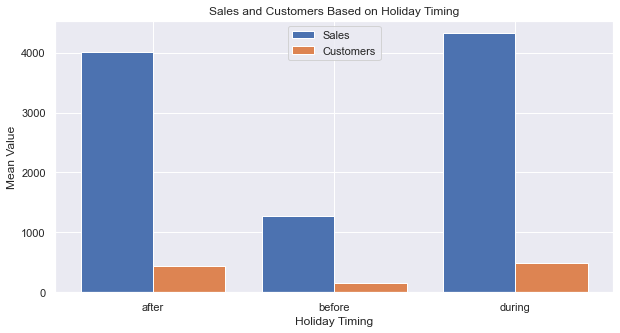

In [21]:
sales_timing_list = modify_holiday_list(state_holiday_list)
timing_added_df = train_df.loc[:,['Sales','Customers']]
timing_added_df['HolidayTiming'] = sales_timing_list
grouped_timing = timing_added_df.groupby('HolidayTiming').agg(
    {'Sales': 'mean', 'Customers': 'mean'})
grouped_timing = grouped_timing.iloc[:3, :]

plt.figure(figsize=(10,5))
X_axis = np.arange(len(grouped_timing.index))
plt.bar(X_axis - 0.2, grouped_timing['Sales'], 0.4, label='Sales')
plt.bar(X_axis + 0.2, grouped_timing['Customers'], 0.4, label='Customers')

plt.xticks(X_axis, grouped_timing.index)
plt.xlabel("Holiday Timing")
plt.ylabel("Mean Value")
plt.title("Sales and Customers Based on Holiday Timing")
plt.legend()

## Sales during holiday is somehow significant than that of before and after holiday. 

### ---------------------------------------------------------------------------------------------------------------------------------------------------
# 3. Find out seasonal purchase behaviour

In [22]:
train_df['Year'] = train_df['Date'].apply(lambda x: int(str(x)[:4]))
train_df['Month'] = train_df['Date'].apply(lambda x: int(str(x)[5:7]))


test_df['Year'] = test_df['Date'].apply(lambda x: int(str(x)[:4]))
test_df['Month'] = test_df['Date'].apply(lambda x: int(str(x)[5:7]))

train_df['Date'] = train_df['Date'].apply(lambda x: (str(x)[:7]))
test_df['Date'] = test_df['Date'].apply(lambda x: (str(x)[:7]))

In [23]:
average_sales = train_df.groupby('StateHoliday')["Sales"].mean()


[Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, 'a'),
 Text(0, 0, 'b'),
 Text(0, 0, 'c')]

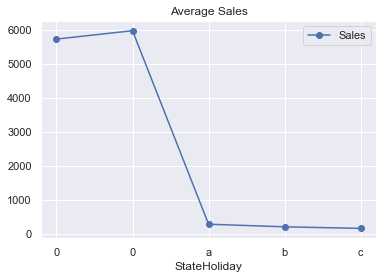

In [34]:
ax1 = average_sales.plot(legend=True,marker='o',title="Average Sales")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist())

In [35]:
seasonal = train_df.groupby('StateHoliday').agg({'Sales':'mean', 'Customers':'mean'})
seasonal = seasonal.iloc[2:,:]
seasonal.head()

,Sales,Customers
StateHoliday,,
a,290.735686,43.817670
b,214.311510,36.561883
c,168.733171,27.174390


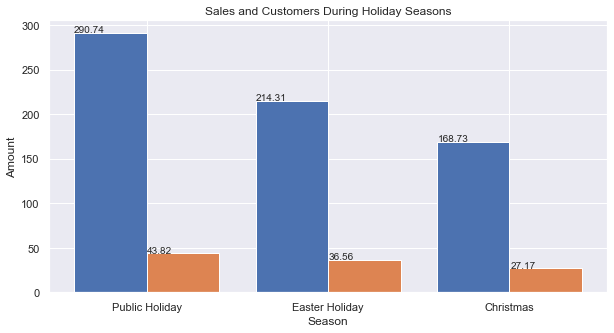

In [36]:
# seasonal index
seasonal.index = ['Public Holiday','Easter Holiday','Christmas']
X_axis = np.arange(len(seasonal.index))
plt.figure(figsize=(10, 5))
plt1 = plt.bar(X_axis - 0.2, seasonal['Sales'], 0.4, label='Sales')
for p in plt1.patches:
    plt.annotate('{:.2f}'.format(p.get_height()), (p.get_x()
                * 1.005, p.get_height() * 1.005))
plt2 = plt.bar(X_axis + 0.2, seasonal['Customers'], 0.4, label='Customers')
for p in plt2.patches:
    plt.annotate('{:.2f}'.format(p.get_height()), (p.get_x()
                                       * 1.005, p.get_height() * 1.005))     
plt.xticks(X_axis, seasonal.index)
plt.xlabel("Season")
plt.ylabel("Amount")
plt.title("Sales and Customers During Holiday Seasons")
plt.show()

## So on public holidays, more sales and customers are observed followed by easter and christmas holiday seasons. 

### -----------------------------------------------------------------------------------------------------------------------------------------------------
# 4. What can you say about the correlation between sales and number of customers?

In [43]:
rel = train_df.loc[:,['Sales','Customers']]
corr = rel.corr()
corr.head()

,Sales,Customers
Sales,1.000000,0.894711
Customers,0.894711,1.000000


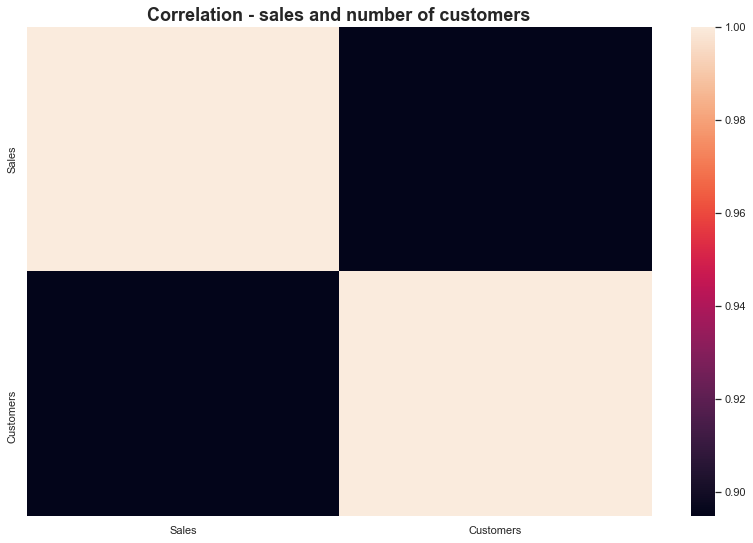

In [44]:
dataExplorer.plot_heatmap_from_correlation(corr, 'Correlation - sales and number of customers')

### correlation between customers and sales is around 0.90. So we can say that number of customers and sales are highly correlated, and as one increases the other will also increase.  

### ---------------------------------------------------------------------------------------------------------------------------------------------------------
# 5. How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?

In [45]:
rln = cl_trainStore.loc[:,['Sales','Promo']]
corr = rln.corr()
corr.head()

,Sales,Promo
Sales,1.000000,0.461348
Promo,0.461348,1.000000


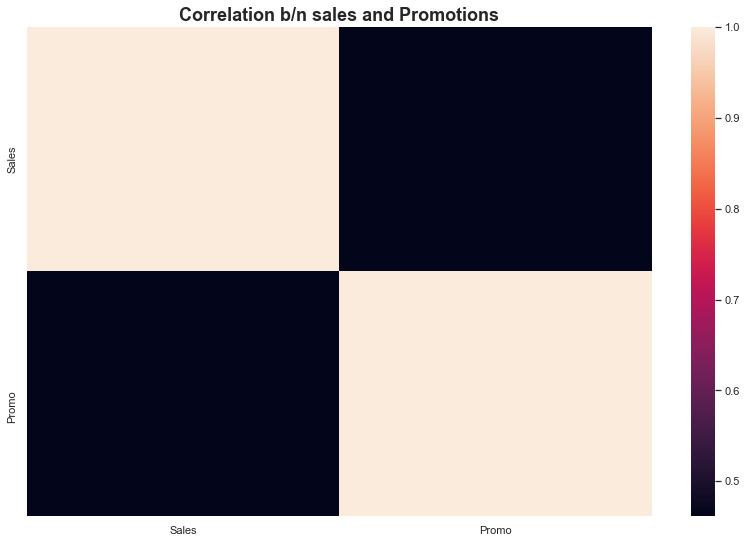

In [47]:
dataExplorer.plot_heatmap_from_correlation(corr, 'Correlation b/n sales and Promotions')

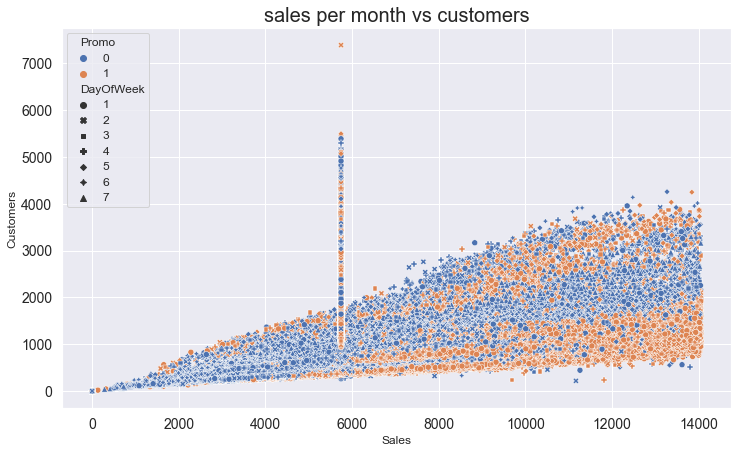

In [50]:
dataExplorer.plot_scatter(cl_trainStore, 'Sales','Customers', 'sales per month vs customers', 'Promo', 'DayOfWeek')

* Promo only moderately affects sales, since their correlation is less than 0.5.
* Both for promoted and not promoted instances, sales increase as customers increase. 
* As customers are directly proportional with sales and sales have a moderate correlation with promo, we expect also a somehow moderate increase in sales for future customers because of continued promotion.

### -----------------------------------------------------------------------------------------------------------------------------------------------------
# 6. Could the promos be deployed in more effective ways? Which stores should promos be deployed in? 

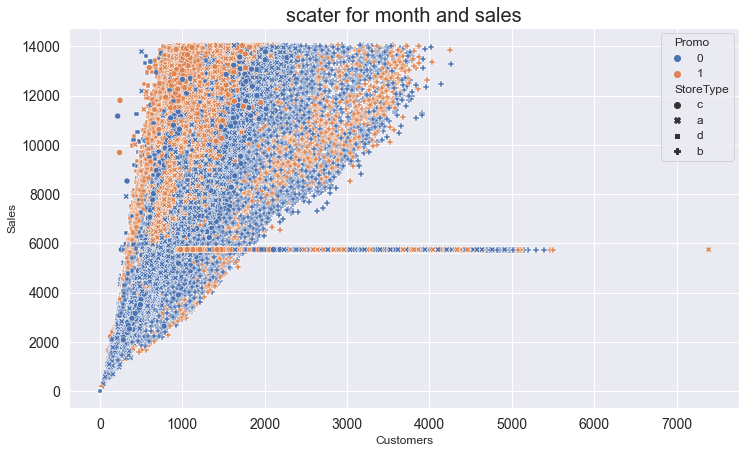

In [66]:
dataExplorer.plot_scatter(cl_trainStore, 'Customers','Sales', 'scater for month and sales', 'Promo', 'StoreType')

In [67]:
seasonal = cl_trainStore.groupby('StoreType').agg({'Sales':'mean', 'Customers':'mean'})
seasonal.head()

,Sales,Customers
StoreType,,
a,5391.371550,659.034880
b,7465.965193,1987.720846
c,5487.990281,673.265894
d,5509.055306,501.434892


### Store type d have less visitors, and store a has less sales relatively, so promoting on these stores will yeild a good  improvement. 

### ------------------------------------------------------------------------------------------------------------------------------------------------------
# 7. Trends of customer behavior during store open and closing times
 

In [70]:
cust = train_df.groupby('Open').agg({'Customers':'mean','Sales':'mean'})
cust.head()

,Customers,Sales
Open,,
0,0.000000,0.000000
1,762.728395,6955.514291


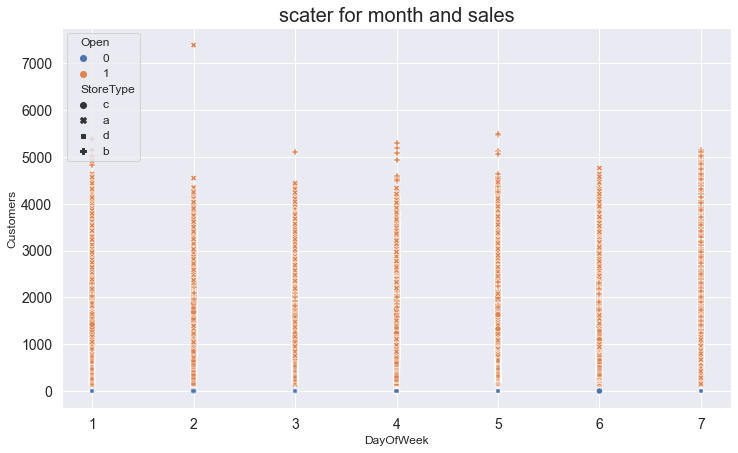

In [76]:
dataExplorer.plot_scatter(cl_trainStore, 'DayOfWeek','Customers', 'scater for month and sales', 'Open', 'StoreType')

# Customers are somehow uniformly visiting the stores, a slight difference on monday and sundays

### ----------------------------------------------------------------------------------------------------------------------------------------------------------
# 8. Which stores are opened on all weekdays? How does that affect their sales on weekends? 


In [87]:
weekly = cl_trainStore.groupby(['StoreType']).agg({'Sales': ['sum'], 'Open': ['sum']})
weekly.columns = ['sales', 'Open']
weekly = weekly.reset_index()
weekly.head()

,StoreType,sales,Open
0,a,2.974026e+09,457077
1,b,1.181862e+08,15563
2,c,7.509766e+08,112978
3,d,1.723850e+09,258774


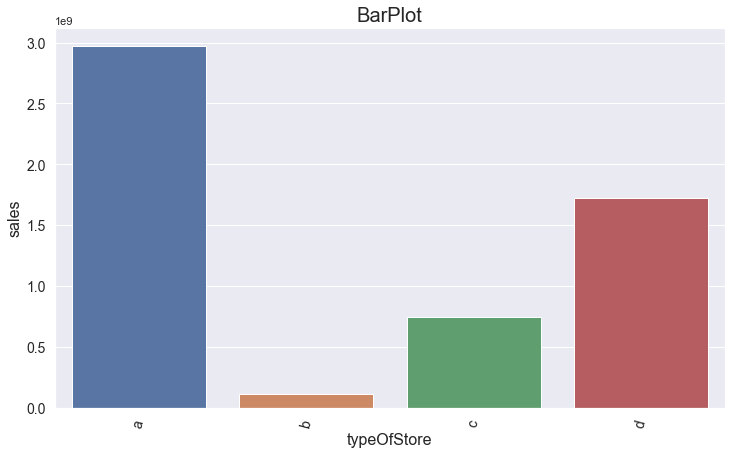

In [90]:
dataExplorer.plot_bar(weekly, 'StoreType', 'sales', 'BarPlot', 'typeOfStore', 'sales')


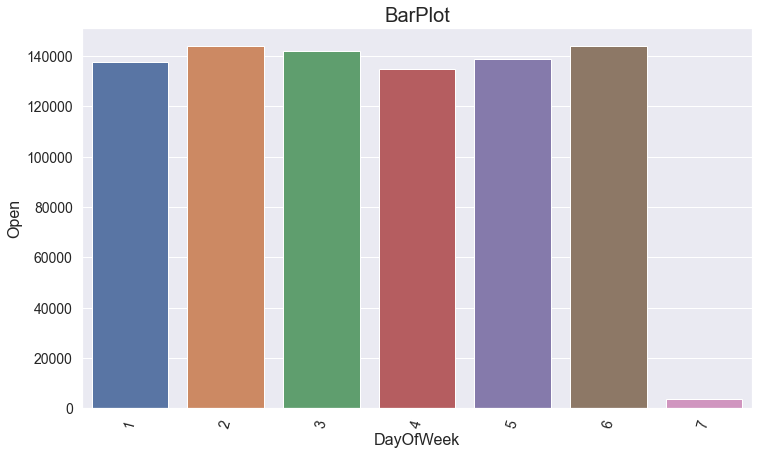

In [84]:
dataExplorer.plot_bar(weekly, 'DayOfWeek', 'Open', 'BarPlot', 'DayOfWeek', 'Open')

In [86]:
weekly_data = cl_trainStore.groupby(['StoreType']).agg({'Open': ['sum'], 'DayOfWeek': ['count']})
weekly_data.columns = ['Open', 'DayOfWeek']
weekly_data = weekly_data.reset_index()
weekly_data.head()

,StoreType,Open,DayOfWeek
0,a,457077,551627
1,b,15563,15830
2,c,112978,136840
3,d,258774,312912


### Store 'a' is the one which is mostly opened, and sales is also higher for that store.

### ------------------------------------------------------------------------------------------------------------------------------------------------------
# 9. Check how the assortment type affects sales 

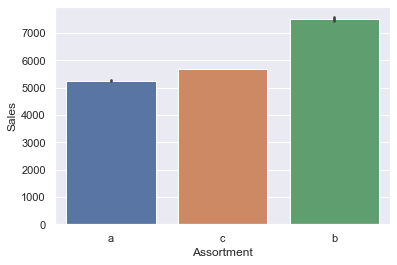

In [93]:
sns.barplot(x='Assortment', y='Sales', data=cl_trainStore)

### b type assortment (Extended stores) generate more revenue.

### -----------------------------------------------------------------------------------------------------------------------------------------------------
# 10. How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centers, does the distance matter in that case?


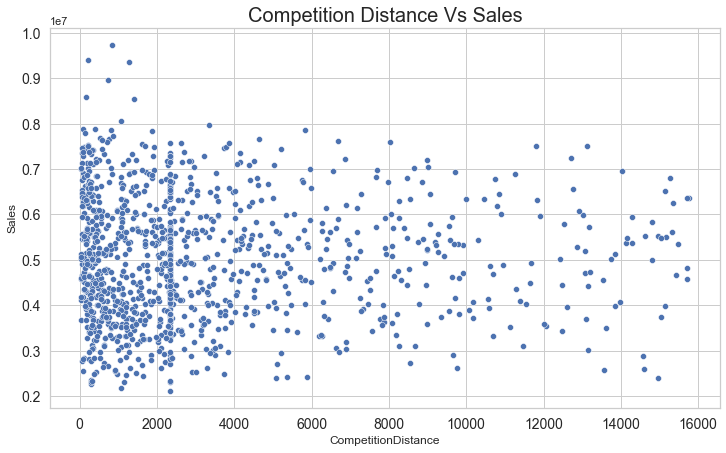

In [127]:
competition_df = cl_trainStore[["Store", "Sales", "Customers", "StoreType", "CompetitionDistance"]]
competition_df_agg = competition_df.groupby("Store").agg({"Sales": "sum", "Customers" : "sum",
                                                      "CompetitionDistance": lambda x: max(x)})

dataExplorer.plot_scatter(competition_df_agg, "CompetitionDistance", "Sales", "Competition Distance Vs Sales", None, None)


In [129]:
competition_df_corr = competition_df[["Sales", "CompetitionDistance"]].corr()
display(competition_df_corr)

,Sales,CompetitionDistance
Sales,1.000000,-0.001675
CompetitionDistance,-0.001675,1.000000


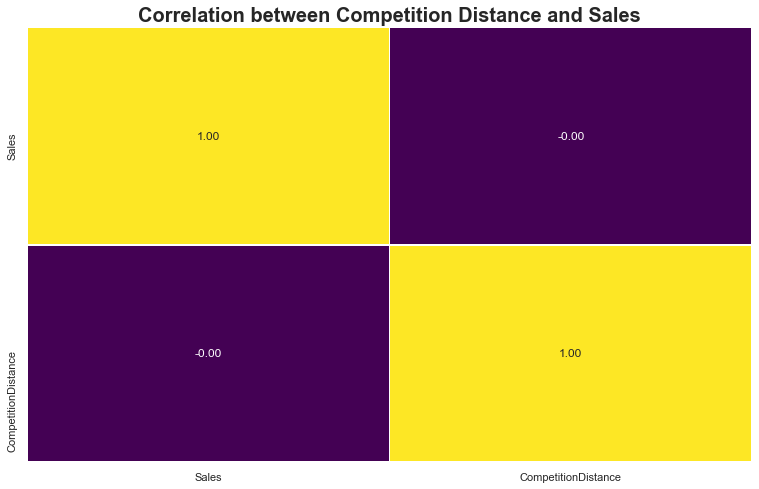

In [130]:
dataExplorer.plot_heatmap(competition_df_corr, "Correlation between Competition Distance and Sales")

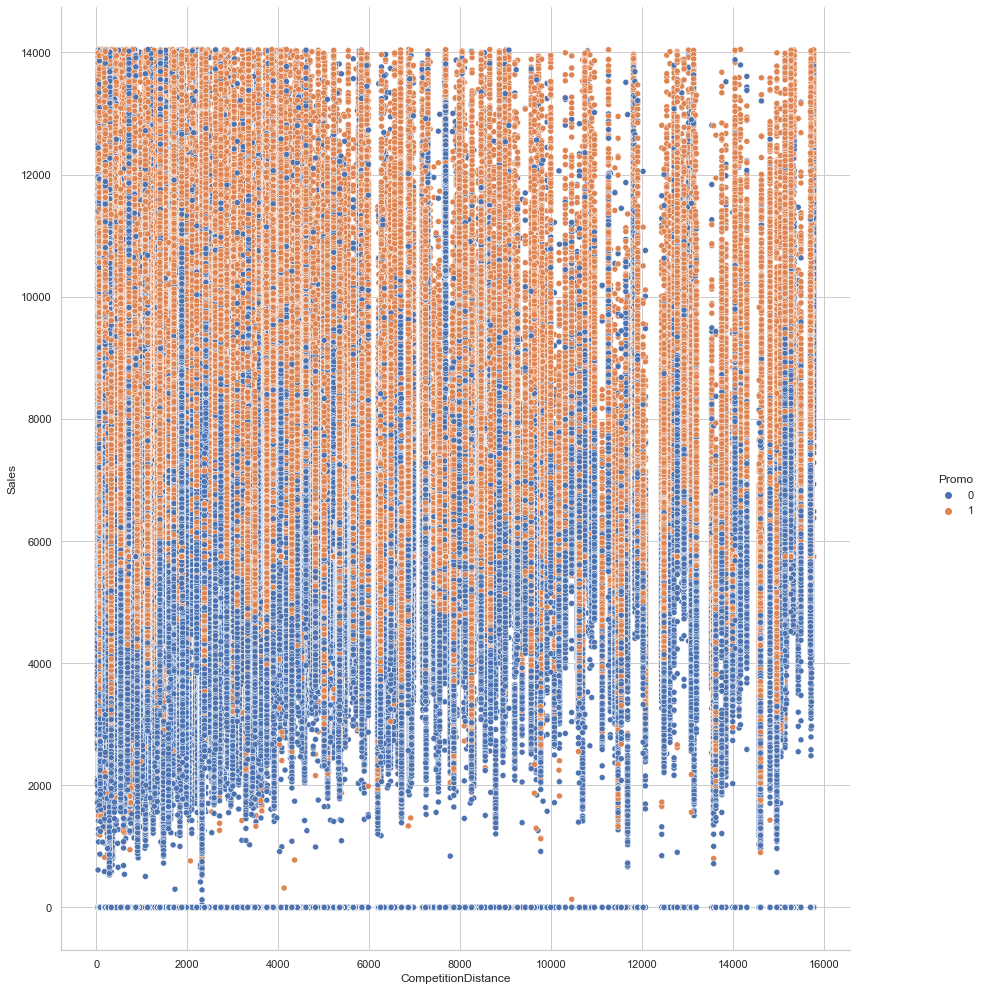

In [133]:
sns.set(style="whitegrid")
g=sns.relplot(x="CompetitionDistance", y="Sales", hue="Promo", data=cl_trainStore)
g.fig.set_size_inches(15,15)

### Scatter plot shows that there is more consentrated sales for shorter competition distances. Also from the correlation map, very low correlation is observed.

### As it can be seen from the last plot, for the competition distances below 2000, the 'not promoted' hues have significant sales. and we have sales for every distance, but as we go far, promoted instances have higher sales.   

### -----------------------------------------------------------------------------------------------------------------------------------------------------------
# 11. How does the opening or reopening of new competitors affect stores? Check for stores with NA as competitor distance but later on has values for competitor distance

In [117]:
has_open_competition_df = cl_trainStore[cl_trainStore['CompetitionOpenSinceMonth'].notnull()]

has_open_competition_df["CompetitionOpenSinceYear"] = has_open_competition_df["CompetitionOpenSinceYear"].astype("int").astype("str")
has_open_competition_df["CompetitionOpenSinceMonth"] = has_open_competition_df["CompetitionOpenSinceMonth"].astype("int").astype("str")

competition_df = has_open_competition_df[["Date", "Sales", "Store", "CompetitionOpenSinceMonth"]]


competition_df["BeforeCompetition"] = competition_df["Date"] < competition_df["CompetitionOpenSinceMonth"]

competition_df_agg = competition_df.groupby("BeforeCompetition").agg({"Sales": "mean"})

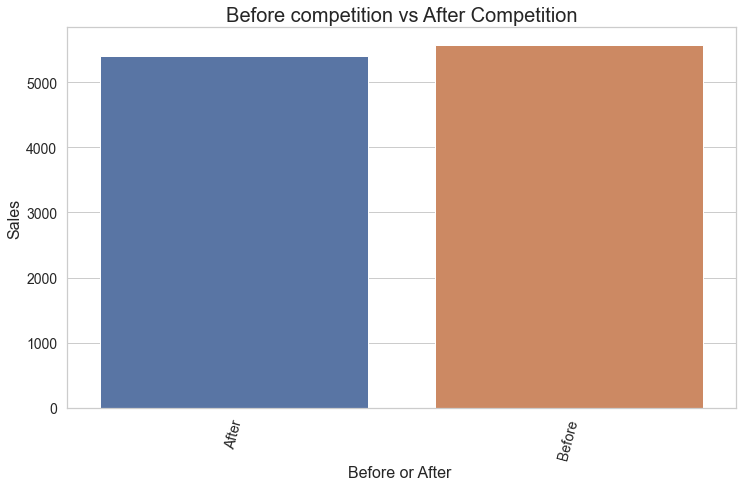

In [118]:
x_col = []
for val in competition_df_agg.index.to_list():
    if (val):
        x_col.append("Before")
    else:
        x_col.append("After")

dataExplorer.plot_bar(competition_df_agg, x_col,
               "Sales", "Before competition vs After Competition",
               "Before or After ", "Sales")

In [119]:
print("Overall avg sales before competition and after competition")
display(competition_df_agg)

decrease = competition_df_agg["Sales"][True] - competition_df_agg["Sales"][False]
decrease_percent = decrease / competition_df_agg["Sales"][True]

print(f"Overall avg sales decreased after competition by {decrease_percent * 100:.3f}%")

Overall avg sales before competition and after competition


,Sales
BeforeCompetition,
False,5402.477993
True,5563.154034


Overall avg sales decreased after competition by 2.888%


### As you can observe from the graph the sales has dropped when new competition is opened.
### But the effect is not that much, it only decreased by 3.693%

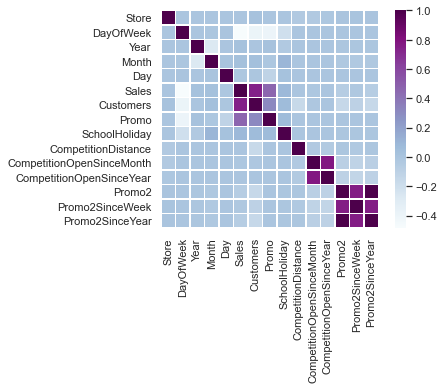

In [136]:
## plot for correlation of all features
correlation = cl_trainStore.drop('Open', axis = 1).corr()
sns.heatmap(correlation, square = True, linewidths = .5, cmap = "BuPu")

* Customers and sales are moderately correlated.
* sales and promo have a correlation of about 0.4.
* sales and promo with dayOfWeek are least correlated features. 